<div style="border: 2px solid red; padding: 2rem; border-radius: 8px">
<h1 style="text-align: center; color: #03182f"> Product Categorization POC </h1>
</div>


In [106]:
# Data wrangling
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Stat analysis
from scipy.stats import f_oneway, kruskal, pearsonr, spearmanr

# ML modeling
## Metrics 
from sklearn.metrics import (classification_report, confusion_matrix, log_loss, roc_auc_score,
                             accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score,
                            ConfusionMatrixDisplay)

## Models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics as kmets
import tensorflow as tf

from keras.models import load_model

import joblib

# deactivate warnings
import warnings
warnings.filterwarnings("ignore")

In [156]:
# To run this notebook, refer to the requirements.txt file, generated from the virtual environnement this notebook was run inside)
# Through:  `pip freeze > requirements.txt`

# Load the data

In [3]:
data_root_path = "" # Put you data root path here
train_path = f"{data_root_path}data_train_final.csv"
test_path = f"{data_root_path}data_test_final.csv"
meta_path = f"{data_root_path}category_parent.csv"

In [139]:
cat_parent_df = pd.read_csv(meta_path)
cat_parent_df["parent_id"] = cat_parent_df["parent_id"]

In [5]:
df_full = pd.read_csv(train_path)
df_full_test = pd.read_csv(test_path)

In [6]:
train_data = df_full.copy().drop(["product_id"], axis=1)
test_data = df_full_test.copy().drop(["product_id"], axis=1)
X_train, y_train = train_data.drop(["category_id"], axis=1), train_data["category_id"]
X_test, y_test = test_data.drop(["category_id"], axis=1), test_data["category_id"]

# Exploratory data analysis

As clearly stated in the guidelines, the provided features are not interpretable and are already transformed. For my analysis, this means that I would not be spending time analyzing the features for semantic purposes, but only for pure statistical purposes (correlation between the features and the target, feature distribution...). 

In [21]:
# Force display all rows and columns in pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [9]:
train_data.describe()

,category_id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
count,241483.000000,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,241483.000000,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05,2.414830e+05
mean,6952.661363,2.861053e-08,2.010980e-07,-2.481093e-11,-2.623515e-07,-2.622769e-07,-6.081859e-08,-1.121595e-07,-6.476297e-08,9.167130e-08,-1.288818e-07,8.221636e-08,1.373803e-07,8.812304e-08,1.870819e-07,5.011504e-08,-2.136818e-07,-1.610265e-07,-3.548563e-08,-8.637254e-08,-4.704789e-08,4.646872e-08,1.670049e-07,8.377850e-08,-1.728005e-07,7.049260e-08,1.272054e-07,-1.765149e-08,-9.348074e-08,1.730435e-08,-1.174268e-08,-8.541048e-08,6.047834e-08,-1.096807e-07,-2.663532e-08,1.410359e-07,-2.481311e-07,8.298271e-08,3.423391e-07,-2.528159e-07,1.046772e-07,1.214162e-08,6.848695e-08,9.083862e-08,9.266941e-08,-2.959325e-08,5.465228e-09,-8.881864e-08,1.492217e-07,2.402212e-08,1.297192e-07,-1.775064e-07,-1.175552e-07,5.232162e-09,-4.349161e-08,1.335167e-07,-7.167703e-08,-6.026953e-08,7.228797e-08,-6.150541e-08,2.066378e-07,-1.210154e-07,2.981895e-08,1.066025e-07,1.877749e-08,-7.312276e-08,-7.293782e-08,-8.250508e-08,1.800825e-07,3.735838e-08,-4.894026e-08,-2.822944e-08,3.984548e-08,7.254236e-08,1.015555e-08,-1.636833e-08,-7.781278e-08,2.503659e-07,-5.092090e-08,-3.271114e-08,-1.081699e-07,-1.110920e-07,1.982598e-07,-5.251438e-08,6.817116e-08,-2.227965e-08,1.380173e-07,-2.048225e-08,2.943203e-08,3.624816e-08,1.572654e-07,-6.085911e-08,1.932072e-07,-1.042031e-07,8.363217e-10,-3.118882e-08,-1.535026e-08,-2.404193e-07,1.347114e-07,-5.073864e-08,-9.048396e-08,99.999999,3.980653e-08,-1.058175e-07,-8.216845e-08,6.292214e-08,1.462838e-07,-2.836419e-08,-2.068844e-08,2.341625e-08,1.691247e-07,1.218839e-07,-4.384908e-09,7.673140e-08,7.928185e-08,2.430603e-08,-3.324822e-08,-2.725335e-08,-3.519811e-08,4.846944e-08,2.067574e-08,1.208172e-07,1.192442e-07,-9.068683e-08,4.360788e-08,2.105384e-08,5.476209e-08,-2.215784e-08,-1.188043e-07
std,4548.216962,1.073000e-01,8.9

First things to notice is that we don't have any missing values, which is always good news as no data imputation or sub-sampling is needed. Thus we don't risk any information loss.

- #### First things first, how are the target classes distributed ?

(NB: Nice to know that no new categories have to be accounted for in the training for potential need durring inference time, which I will assume for this analysis.)

In [154]:
# helper functions
def style(fnc):
    """Add some matplotlib styling."""
    def inner(*args, **kwargs):
        sns.set_style("whitegrid")
        fnc(*args, **kwargs)
        ax = kwargs.pop("ax", None)
        if ax:
            ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),
                       loc="lower left",
                       mode="expand",
                       borderaxespad=0,
                       ncol=2)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
        plt.tight_layout()
    return inner

In [11]:
cat_count_df = df_full[["category_id","product_id"]].groupby(by="category_id").count().sort_values("product_id", ascending=False).rename({"product_id": "count"}, axis=1)
cat_count_df = cat_count_df.sort_values(by="count", ascending=False)
cat_count_df.head()

,count
category_id,
9820,10009
9821,7125
3056,6862
5662,5677
5661,5441


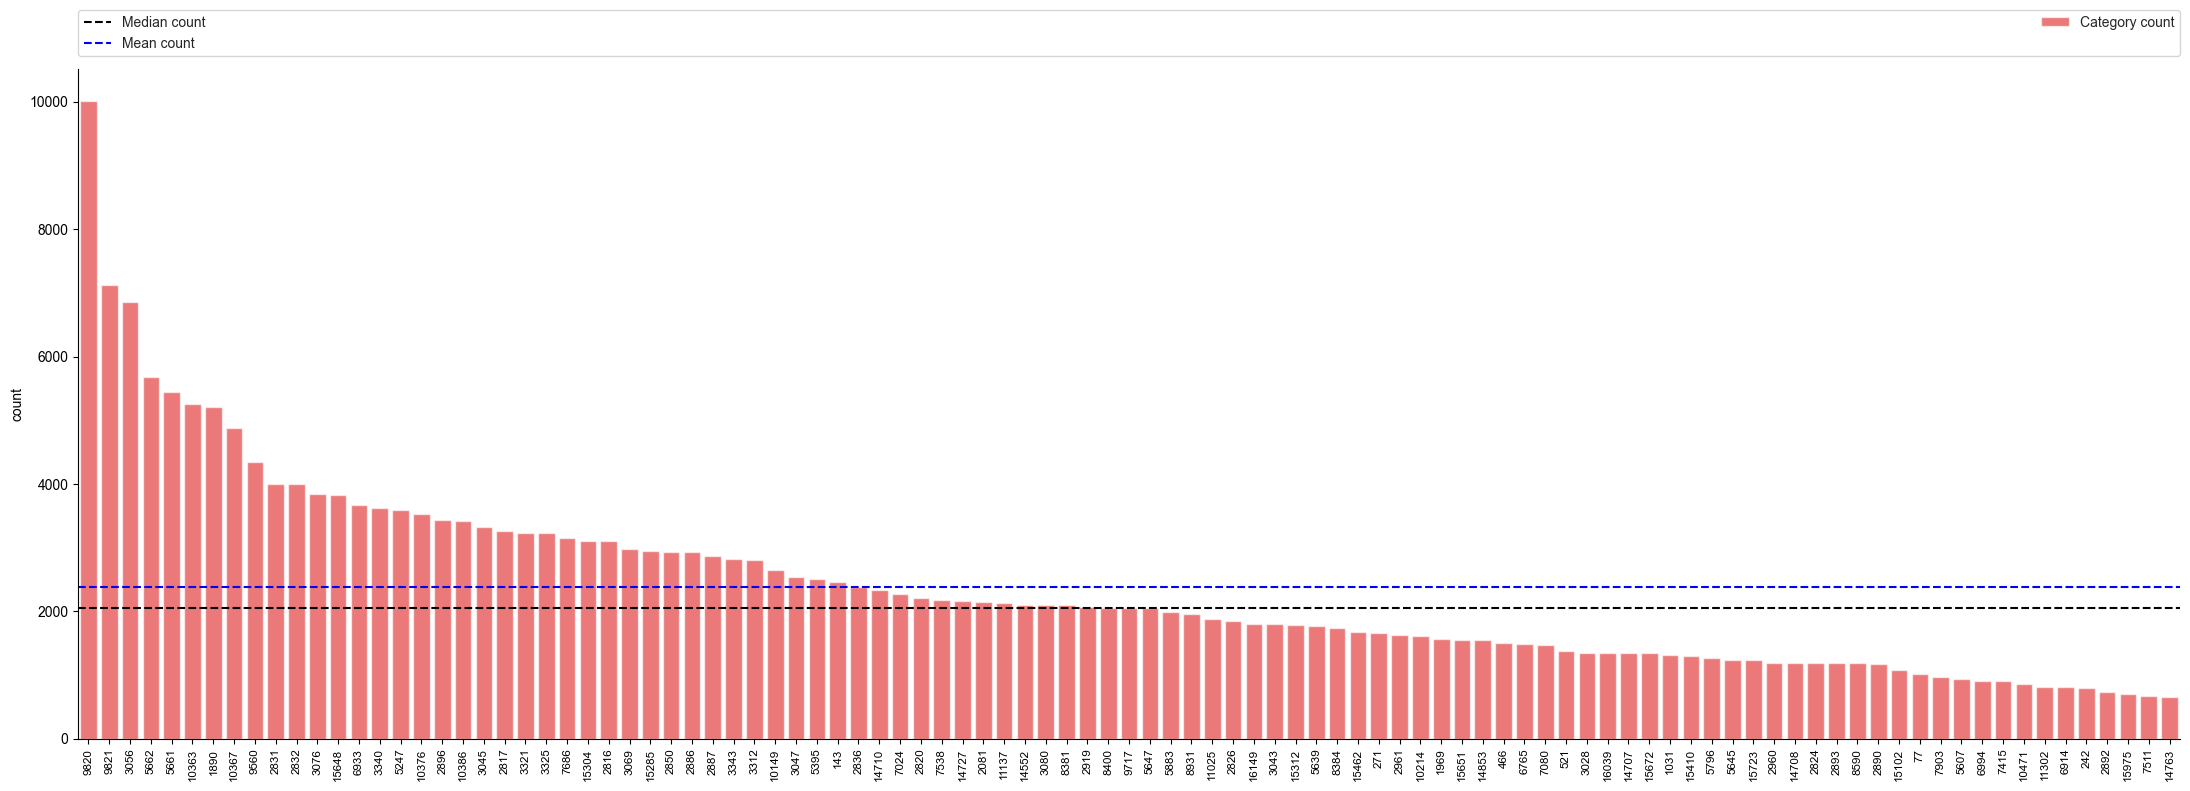

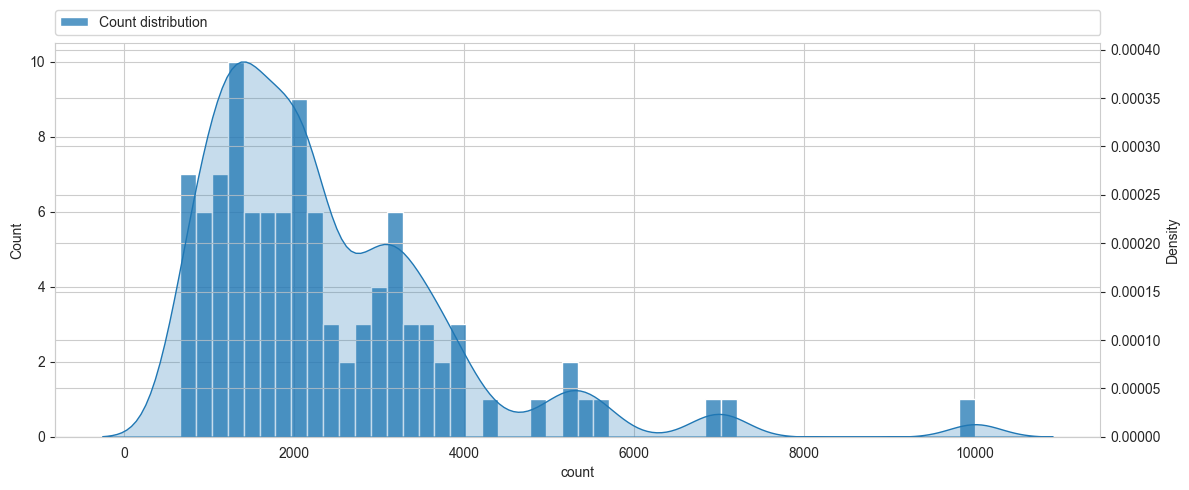

In [12]:
@style
def plot_category_count(ax, cat_count_df):
    sns.barplot(x=range(cat_count_df.shape[0]), y=cat_count_df['count'], ax=ax, label="Category count",
               color="red", alpha=0.6)
    ax.set_xticklabels(cat_count_df.index,
                       rotation=90,
                       fontsize="small")

    ax.axhline(y=cat_count_df['count'].median(), label="Median count",
               linestyle='dashed', color='k', lw=1.5)
    ax.axhline(y=cat_count_df['count'].mean(), label="Mean count",
               linestyle='dashed', color='b', lw=1.5)
    
@style
def plot_count_distribution(ax, cat_count_df):
    sns.histplot(cat_count_df["count"], bins=50, ax=ax, label="Count distribution")
    ax_twin = ax.twinx()
    sns.kdeplot(cat_count_df["count"], ax=ax_twin, bw_adjust=0.5, shade=True)


_, ax = plt.subplots(figsize=(22,8))
plot_category_count(ax=ax, cat_count_df=cat_count_df)

_, ax2 = plt.subplots(figsize=(12,5))
plot_count_distribution(ax=ax2, cat_count_df=cat_count_df)

We clearly see that some categories are more represented than others in the training dataset. This is something we might want to pay attention to in the modeling part, especially if the less represented categories are to be missclassified by our model.

- #### What about the explanatory variables ?

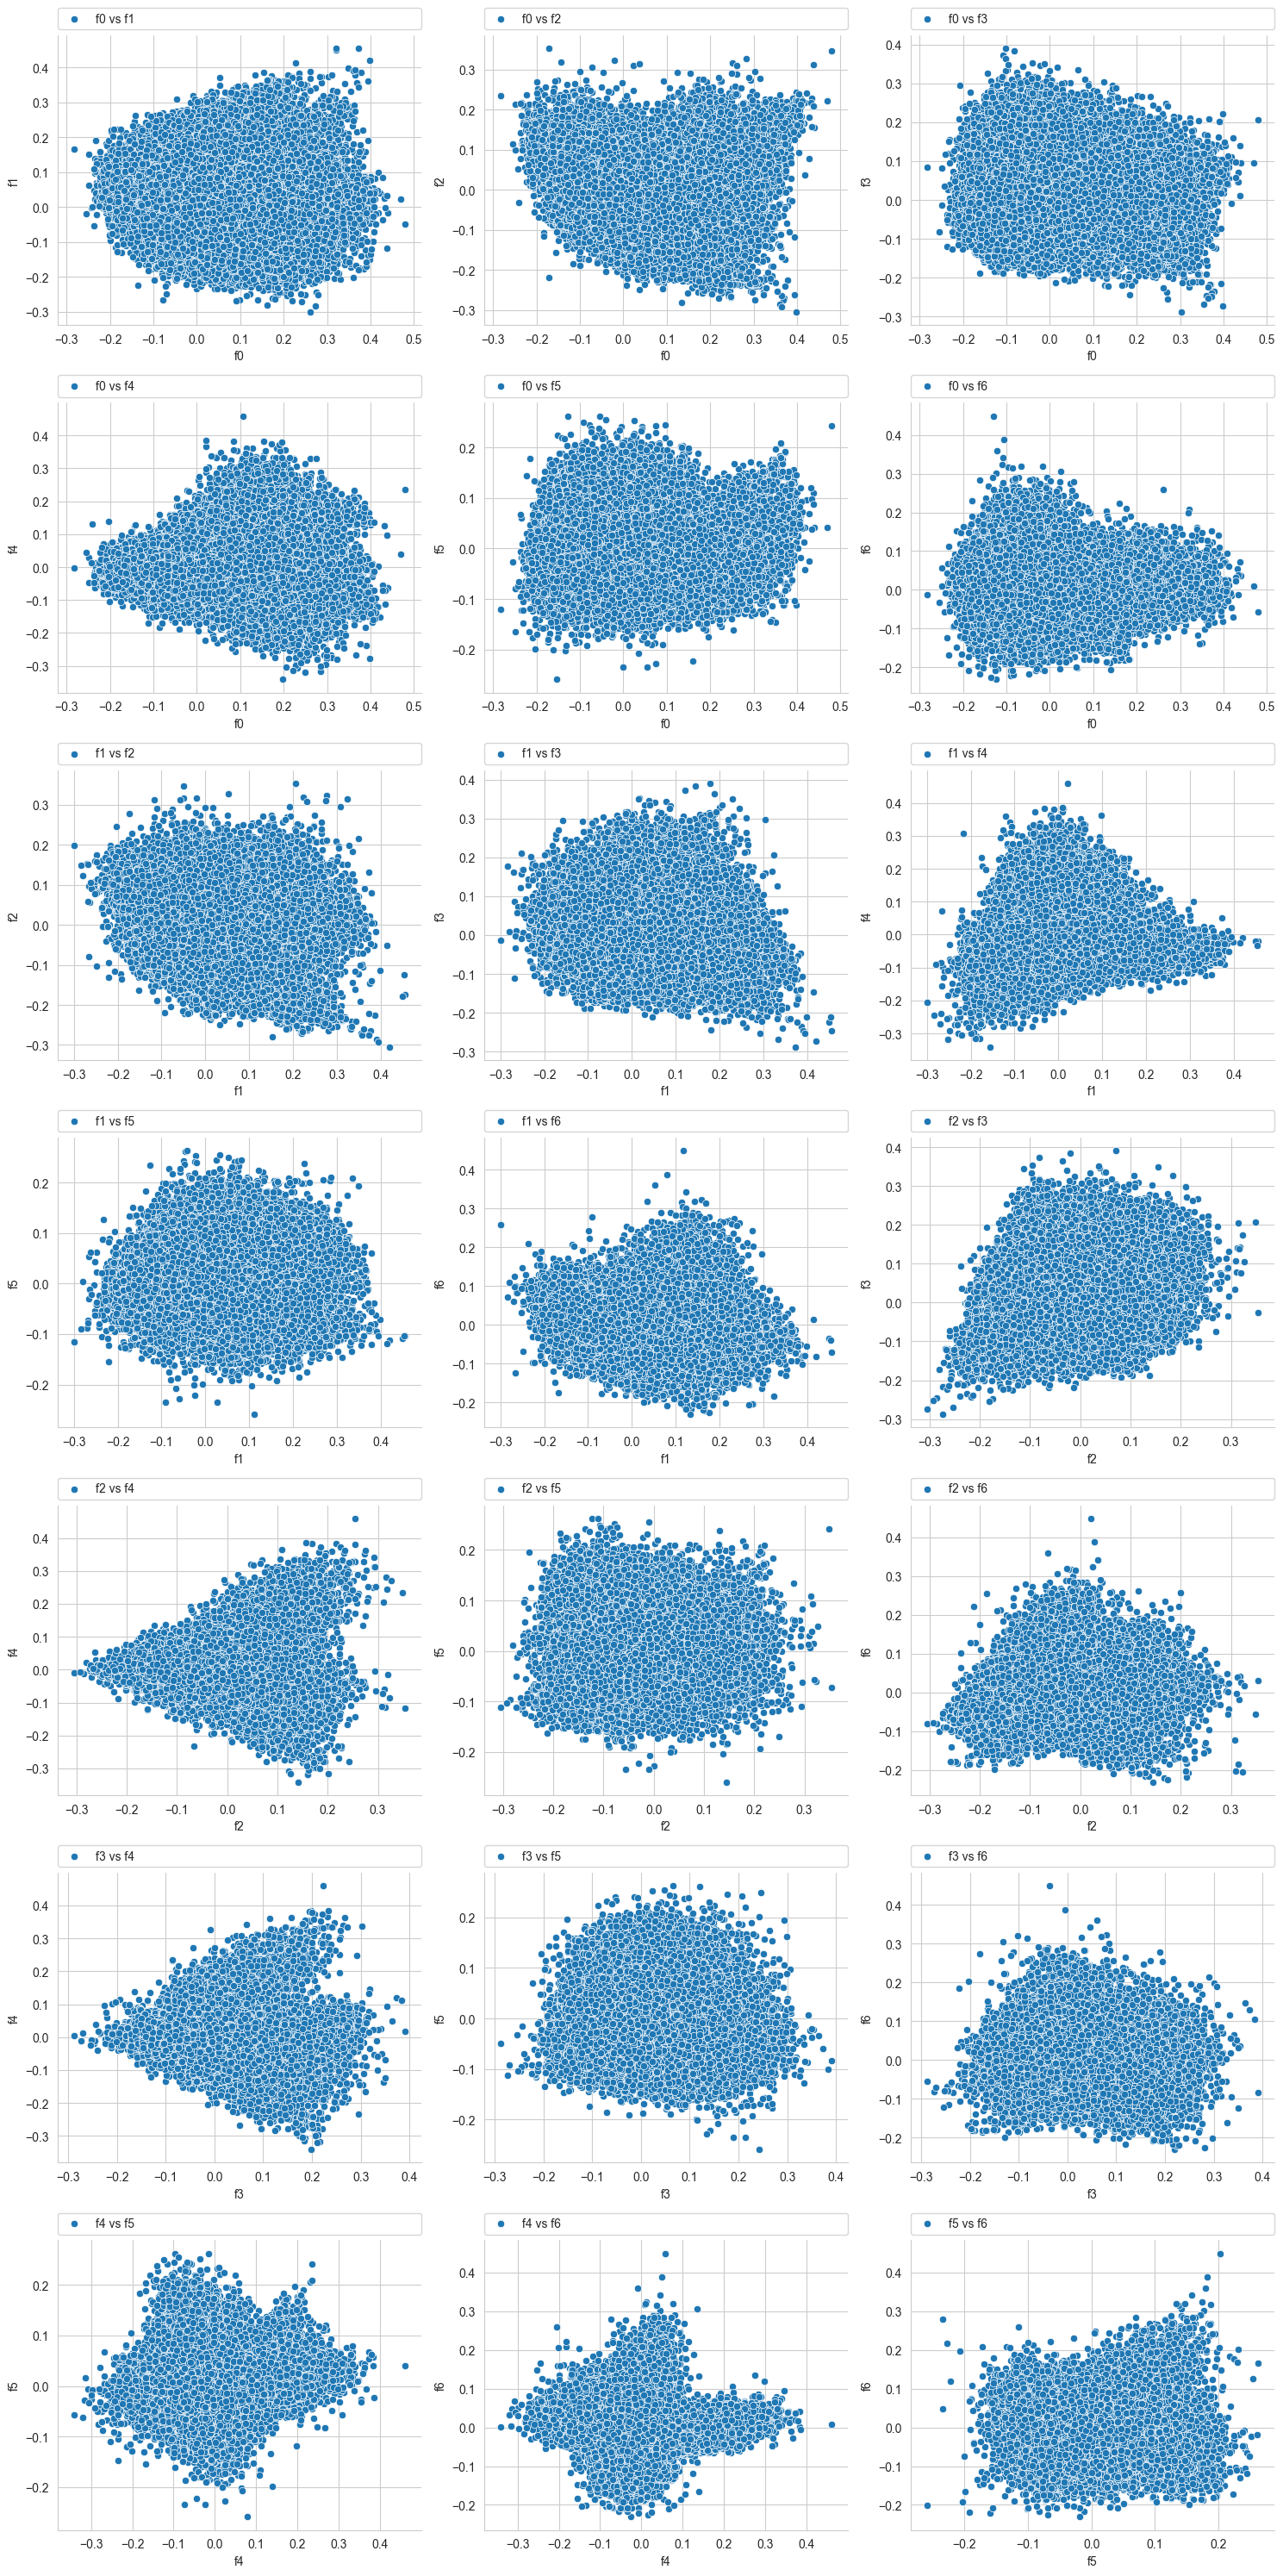

In [13]:
sub_train = X_train.iloc[:, :7].copy()
_, axes = plt.subplots(ncols=3, nrows=7, figsize=(15,30))
axes = axes.flatten()

@style
def plot_bitwise_scatter(ax, x, y, label):
    sns.scatterplot(x=x, y=y, ax=ax, label=label)
    
    
k = 0
for i, col1 in enumerate(sub_train.columns[:-1]):
    for j, col2 in enumerate(sub_train.columns[i+1:]):
        plot_bitwise_scatter(ax=axes[k], x=sub_train[col1], y=sub_train[col2], 
                             label=f"{col1} vs {col2}")
        k += 1
plt.show()

<Axes: >

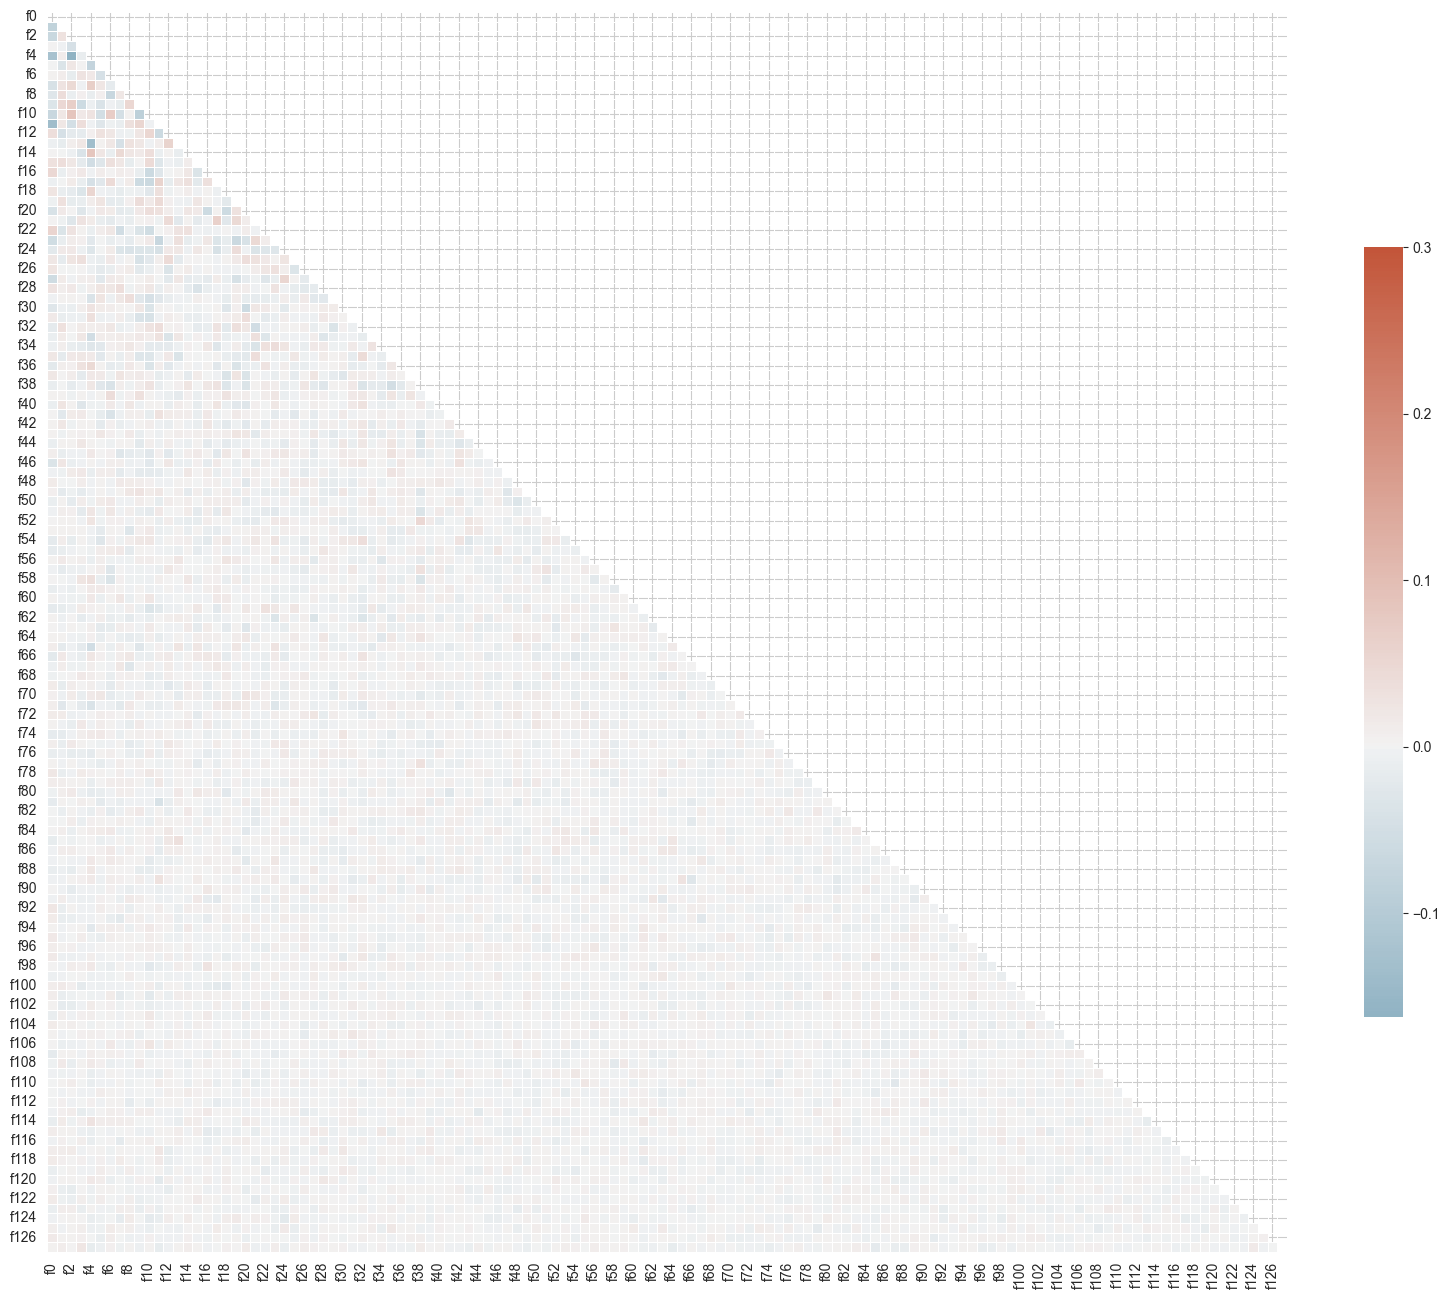

In [14]:
# Compute the correlation matrix
corr = X_train.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

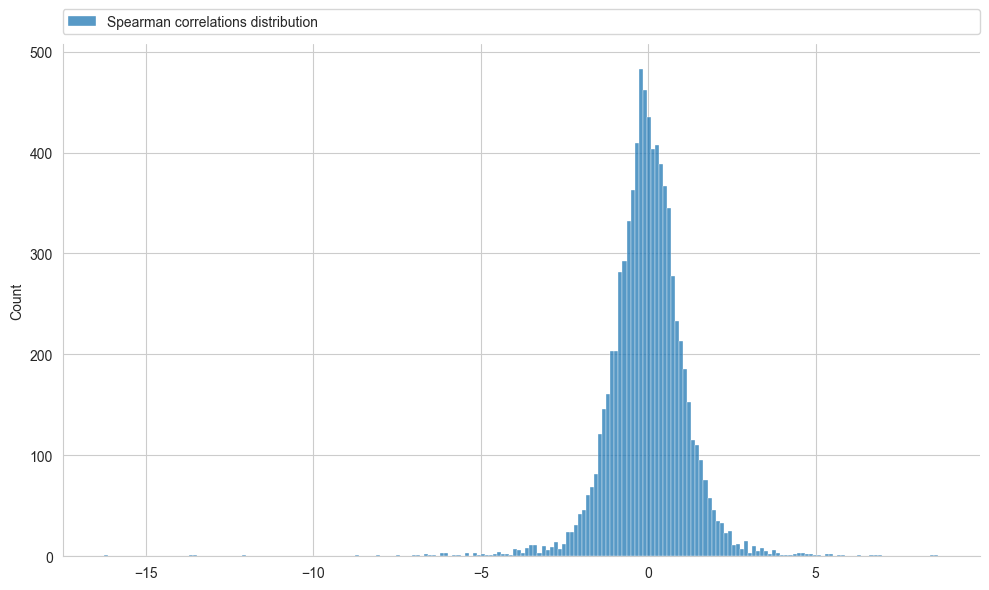

In [15]:
triangle_correlations = np.array([corr.iloc[i,j]*100 for i in range(corr.shape[0]-1) for j in range(i+1, corr.shape[0])])

@style
def plot_correlation_distribution(ax, data):
    sns.histplot(data, label="Spearman correlations distribution", ax=ax)
    
_, ax = plt.subplots(figsize=(10,6))
plot_correlation_distribution(ax=ax, data=triangle_correlations)

Looking into the plots of the explanatory features and the correlation between variables, we have a minimal reason to assume the variables are not correlated. Deeper analysis can be done to better assess the absence of Collinearity (through the variance inflation factor for example)

- #### An idea about the relationship between the target and the explanatory variables ?

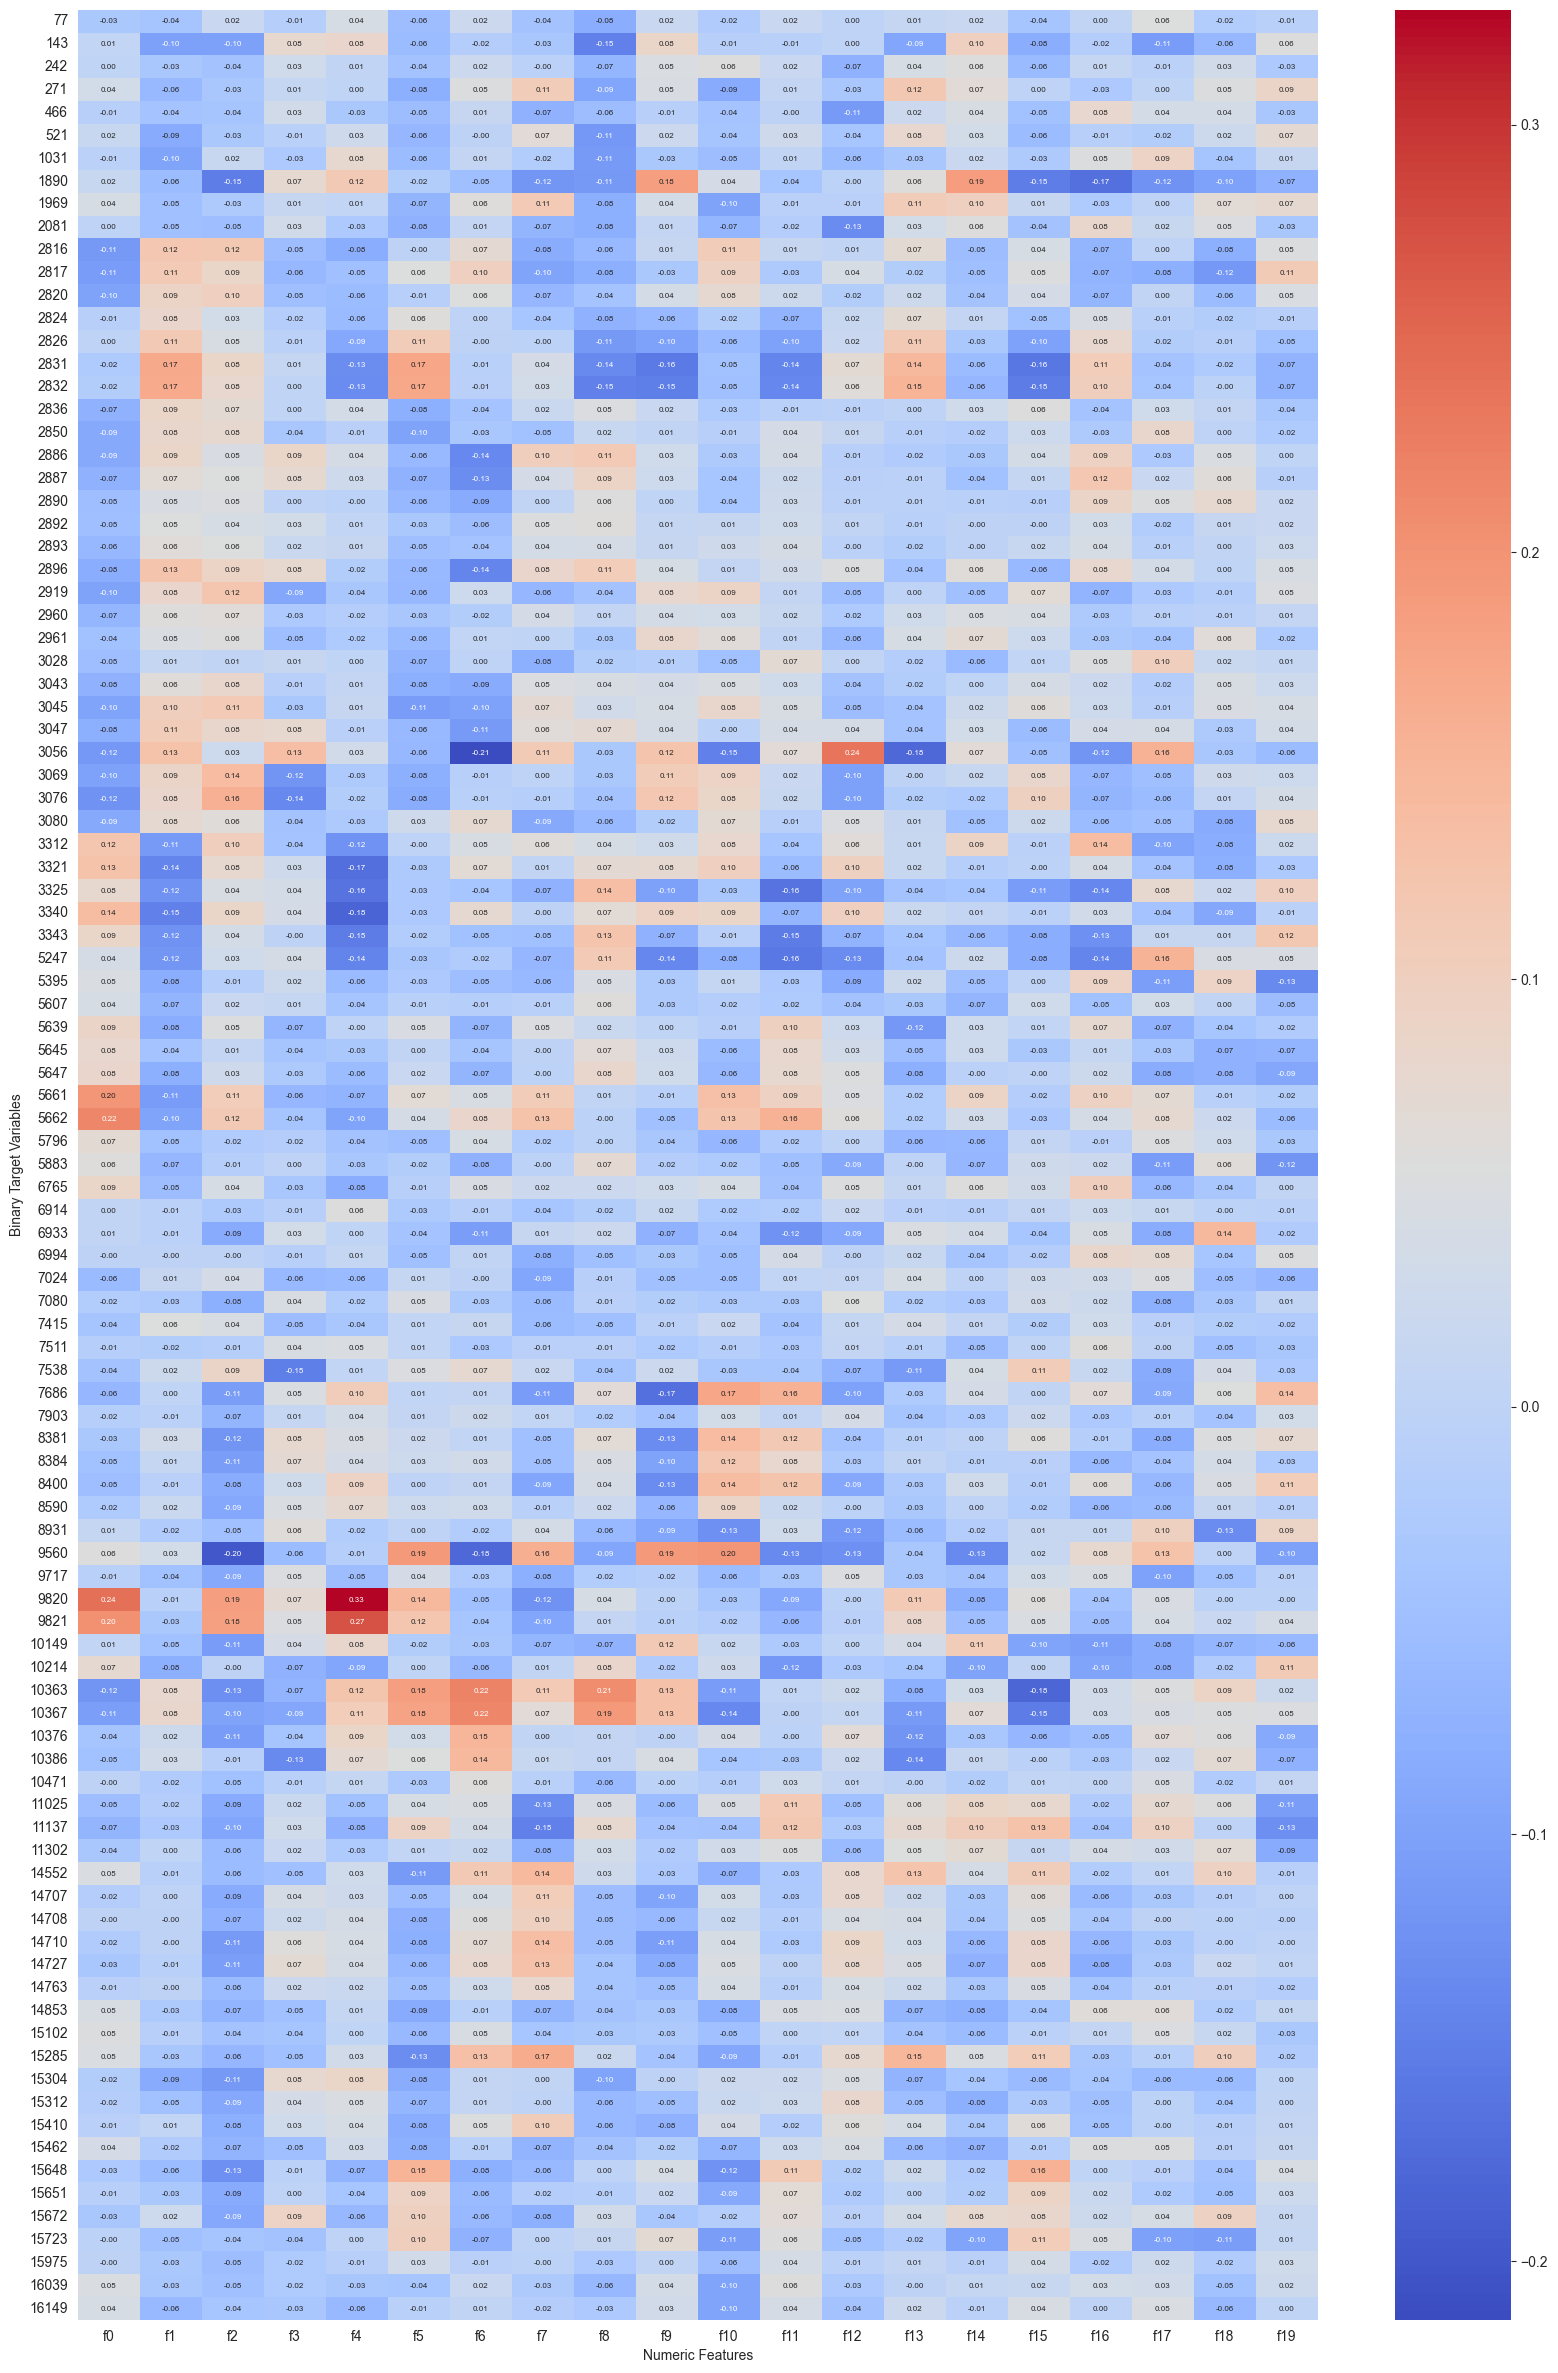

In [21]:
def plot_feature_target_class_correlation_matrix(y, X, ax_corr):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    ohe = OneHotEncoder(sparse_output=False)
    y_onehot = ohe.fit_transform(y_encoded.reshape(-1, 1))

    corr_matrix = np.zeros((y_onehot.shape[1], X.shape[1]))
    for i in range(X.shape[1]):
        for j in range(y_onehot.shape[1]):
            corr, _ = spearmanr(X.iloc[:, i], y_onehot[:, j])
            corr_matrix[j, i] = corr

    corr_matrix_df = pd.DataFrame(corr_matrix, columns=X.columns, index=le.classes_)

    sns.heatmap(corr_matrix_df, cmap='coolwarm', annot=True, fmt='.2f', ax=ax_corr, annot_kws=dict(fontsize="xx-small"))
    plt.xlabel('Numeric Features')
    plt.ylabel('Binary Target Variables')
    plt.show()

_, X_corr, _, y_corr = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
_, ax_corr = plt.subplots(figsize=(20, 30))

plot_feature_target_class_correlation_matrix(y_corr, X_corr.iloc[:, :20], ax_corr)

Looking at the correlation matrix between each variable and a target's class, we validate the importance of the provided features beforehand. 

# Modelisation

Given the nature of the provided data, we are facing a supervised learning problem. More specifically a classification problem. There are two approaches we can use to model the problem: Either as a multiple binary classification problem or as a multi-class classification problem.

### 1) As a binary classification problem:

This means that we are going to create a binary classifier for each class. Once the one-class classifiers are constructed, we can just pick the class with the highest predicted probability during inference. We can also think of more sophisticated methods to extract the actual class from the one-class classifiers. In the case of multiple classes having close predicted values, we can think of one-vs-one classifiers to get a more reliable prediction. 

The issue with this last approach is that we will have to train an additional $N*(N-1)/2$ classifiers ($N$: number of classes). So before, doing this, a point has to be made that this would benefit the performance of the prediction, as the inference time will be worsened. Regardless, we still have to run at least $N$ inferences to get the final prediction.

Thus, if we are going to use this first approach, it is important to use efficient models, so the inference time is not badly affected.

The main advantage of this approach is that the learning task is easier for the classifiers. Intuitively, we know for example that it is easier to ask a model to learn if a product is Man's T-shirt or not, than if it is a Man's T-shirt, a Kitchen Appliance or a Woman's T-shirt. Technically talking, the model would have to learn less parameters with the former, which reduces its complexity.

Some base models we can use as binary classifiers are:

- Logistic regression
- Support Vector Machines
- Ensemble models: Random forests, 
- Boosting models: Gradient boosting trees ...

We will be using a simple logistic regression for this usecase for the reasons below:

- This is the model with the least inference time. This asnwers our efficiency constraint for building multiple one-class classifiers. The inference being a simple dot product between $N+1$ weights and the input, followed by a sigmoid.
- Some assumptions of this linear model seem already verified (non collinearity namely, but other assumptions are still to be verified later (heteroscedasticity, linearity, residuals normality ...)).
- ( Not because other one-vs-rest models just overcommited my laptop's memory and Colab's 😄)


### 2) As a multi-class classification problem:

This suggests that the model will have to learn the patterns of all the classes at once. Thus, the target is a multivariate vector of size $N$ (number of classes). This learning task is harder compared to the previous approach. Thus, we will need to use more complex models to capture the patterns of each class, especially that our case we have a lot of classes ($101$ classes).

- K-Nearest neighbors
- Random forests
- Gradient Boosting
- Extreme gradient boosting (LightGBM, XGBoost)
- Extra trees
- Multi-layer Perceptron

As for the previous approach, I will only be using one of the previous models. Each of the previous models are costly in terms of inference time. KNNs implying **SIZE-OF-TRAIN** operations to compute the nearest neighbors. Gradient boosting as well as any other boosting model implies going through all trees. Thus, I will be using an MLP as current MLOps infrastructures are optimized for Deeep Learning mdoels inference. A model like a random forest is also a good alternative as the inference can be accelerated with parallelization.

## Metrics:

When it comes to chosing metrics for our learning problem, as no specific information was provided on whether any classes have higher risk being missclassified (as a False positive or a False negative), we will give the same weight to both the recall and the precision. Thus we will be using the **F1-score** that does just that. We will also keep track of the **recall**, **precision** and **accuracy** (we can only look at the **AUC**). It goes without saying that we will also be looking at the metrics on the overall classes and not only for each class. We will also monitor the top-k scores, to see if the model is struggling overall in the learning process or wether the model has learned a good enough representation making it capable of detecting the right class among the least $k$ classes.

In [140]:
# utils
class_easy_mapper = {}
for i, cat in enumerate(cat_parent_df.category_id):
    class_easy_mapper[cat] = f"C{i}"

for col in cat_parent_df.columns:   
    cat_parent_df[col] = cat_parent_df[col].apply(lambda x: class_easy_mapper.get(x, "C0"))
    
def find_leaf_parents(df):
    """
    Find the parents of each leaf class
    """
    
    leaf_parents_dict = {}
    children_dict = {}
    for _, row in df.iterrows():
        parent = row['parent_id']
        child = row['category_id']
        if parent in children_dict:
            children_dict[parent].append(child)
        else:
            children_dict[parent] = [child]
    children_dict["C0"] = children_dict["C0"][1:] 
    
    def dfs(node, path):
        current_path = path + [node]
        if node not in children_dict:
            leaf_parents_dict[node] = current_path[:-1]  # Exclude the leaf node itself
        else:
            for child in children_dict[node]:
                dfs(child, current_path)
    dfs('C0', [])
    return leaf_parents_dict

leaf_parents = find_leaf_parents(cat_parent_df)
original_parent_mapper = dict()
for key, val in class_easy_mapper.items():
    if class_easy_mapper[key] in leaf_parents:
        original_parent_mapper[key] = leaf_parents[class_easy_mapper[key]]

def misclassification_percentages(confusion_matrix, class_names, top_k=5):
    num_classes = len(confusion_matrix)
    misclassification_data = {}
    for i in range(num_classes):
        row_sums = [sum(row) for row in confusion_matrix]
        col_sum = sum(confusion_matrix[j][i] for j in range(num_classes) if j != i)

        misclassification_data[class_names[i]] = {}

        for j in range(num_classes):
            if j != i:
                misclassification_percentage = confusion_matrix[j][i] / col_sum * 100
                misclassification_data[class_names[i]][class_names[j]] = misclassification_percentage

        sorted_misclassifications = sorted(
            misclassification_data[class_names[i]].items(),
            key=lambda x: x[1],
            reverse=True
        )
        misclassification_data[class_names[i]] = dict(sorted_misclassifications[:top_k])
    df = pd.DataFrame.from_dict(misclassification_data, orient="index")
    return df

In [103]:
def essential_metrics(model, X_train, X_test, y_train , y_test, is_mlp=False, ohe=None):
    # Predict
    if is_mlp:
        y_pred_proba = model.predict(X_test)
        y_pred_proba_train = model.predict(X_train)
        y_pred = ohe.inverse_transform(y_pred_proba)
        y_pred_train = ohe.inverse_transform(y_pred_proba_train)
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba_train = model.predict_proba(X_train)
    
    # Metrics over all classes
    avg_precision_train = precision_score(y_train, y_pred_train, average='weighted')
    avg_precision = precision_score(y_test, y_pred, average='weighted')
    
    avg_recall_train = recall_score(y_train, y_pred_train, average='weighted')
    avg_recall = recall_score(y_test, y_pred, average='weighted')
    
    avg_f1_train = f1_score(y_train, y_pred_train, average='weighted')
    avg_f1 = f1_score(y_test, y_pred, average='weighted')
        
    avg_acc_train = accuracy_score(y_train, y_pred_train)
    avg_acc = accuracy_score(y_test, y_pred)

    top_3_acc_train = top_k_accuracy_score(y_train, y_pred_proba_train, k=3)
    top_3_acc_test = top_k_accuracy_score(y_test, y_pred_proba, k=3)
    top_5_acc_train = top_k_accuracy_score(y_train, y_pred_proba_train, k=5)
    top_5_acc_test = top_k_accuracy_score(y_test, y_pred_proba, k=5)
    top_10_acc_train = top_k_accuracy_score(y_train, y_pred_proba_train, k=10)
    top_10_acc_test = top_k_accuracy_score(y_test, y_pred_proba, k=20)

    print("Metrics over all classes:")
    print(f"F1 Score (train, test):  {avg_f1_train, avg_f1}")
    print(f"Precision (train, test): ({avg_precision_train}, {avg_precision})")
    print(f"Recall (train, test):    ({avg_recall_train}, {avg_recall})")
    print(f"Accuracy (train, test): ({avg_acc_train, avg_acc})")
    print(f"Top-3 Accuracy (train, test): ({top_3_acc_train}, {top_3_acc_test})")
    print(f"Top-5 Accuracy (train, test): ({top_5_acc_train}, {top_5_acc_test})")
    print(f"Top-10 Accuracy (train, test): ({top_10_acc_train}, {top_10_acc_test})")
    
    # Metrics over each class
    classes = ohe.categories_[0] if is_mlp else model.classes_
    
    f1s = f1_score(y_test, y_pred, labels=classes, average=None)
    recalls = recall_score(y_test, y_pred, labels=classes, average=None)
    precisions = precision_score(y_test, y_pred, labels=classes, average=None)
    aucs = roc_auc_score(y_test, y_pred_proba, average=None, multi_class="ovr", labels=classes)
    
    class_train_dist_mapper = train_data.category_id.value_counts().to_dict()
    train_support = [class_train_dist_mapper[class_] for class_ in classes]
    class_parent1 = [original_parent_mapper[class_][1] for class_ in classes]

    classes_metrics_df = pd.DataFrame({ "recall": recalls*100, "precision": precisions*100, 
                                 "f1-score": f1s*100, "aucs": aucs*100, "train-support": train_support,
                                "category-first-parent": class_parent1}, index=classes)
    classes_metrics_df = classes_metrics_df.sort_values(by="f1-score", ascending=False)

    return confusion_matrix(y_test, y_pred), classes_metrics_df

### 1) Using binary classifiers

In [12]:
clf_lr = OneVsRestClassifier(LogisticRegression(multi_class='ovr', random_state=0))
clf_lr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr',
                                                 random_state=0))

In [19]:
conf_matrix_lr, classes_metrics_df_lr = essential_metrics(clf_lr, X_train, X_test, y_train , y_test)

Metrics over all classes:
F1 Score (train, test):  (0.6038996641271855, 0.576661849216164)
Precision (train, test): (0.6248613041469936, 0.6023461736787306)
Recall (train, test):    (0.6265161522757295, 0.6007420984398051)
Accuracy (train, test): ((0.6265161522757295, 0.6007420984398051))
Top-3 Accuracy (train, test): (0.9103580790366196, 0.8975367696365506)
Top-5 Accuracy (train, test): (0.9476940405742847, 0.9392686306942644)
Top-10 Accuracy (train, test): (0.9753233146846776, 0.9872144485672135)


In [22]:
classes_metrics_df_lr

,recall,precision,f1-score,aucs,train-support,category-first-parent
8931,99.574468,94.736842,97.095436,99.972484,1962,C258
9560,97.523220,92.647059,95.022624,99.906440,4347,C259
3056,98.367347,91.386782,94.748666,99.706037,6862,C249
6933,90.812721,79.566563,84.818482,98.165684,3672,C254
5639,93.131868,77.397260,84.538653,99.128527,1765,C253
1031,97.905759,72.200772,83.111111,99.907134,1317,C246
7024,92.418773,74.418605,82.447665,99.802853,2274,C254
11302,88.757396,74.626866,81.081081,99.896159,822,C262
7538,89.866157,69.940476,78.661088,99.684628,2177,C255
5607,82.203390,74.045802,77.911647,99.484502,941,C253


### Commentary on the first approach results:
<hr>
We don't see a big drop in performance between the train and final test sets. We certainly can do better for the used logistic regression. I ommited the warnings, but the optimizer (lbfgs) was clearly not converging. This something we can optimize for durring hyperparametrization of the model by digging deeper into what causes the convergence issue and providing better parametrization. Regularization can also be applied with a Ridge (L2 regularization) or an Elastic Net (L1, L2 regularization) model to favorize model convergence while reducing overfitting.


We clearly see that the model shows a good accuracy at detecting the right label in the top-k classes (with $~94%$ for top 5 classes). We can imporve upon that with one-vs-one classifiers on top of the predicted classes.


Looking at the per-class metrics we clearly see that the model struggles with some classes compared to others. One point of improvement is to look in details into the classifiers of those classes to imporve their performance. Some of those issues are due to class imbalance, so methods like Oversampling, SMOTE or giving more weight to the missclassified classes samples would imporve those classifiers performances.

In [19]:
## Dump / load the model
# joblib.dump(clf_lr, 'models/clf_lr.joblib')
# clf_lr = joblib.load("models/clf_lr.joblib")

['models/clf_lr.joblib']

### 2) Using a multi-class classifier

For this task, as mentionned before, we will go for an MLP. We will use a simple architecture with **two hidden dense layers** each followed by a **Dropout** to **limit the overfitting** of the model. For validation, we create a stratisfied subset of the data. Also, to further avoid overfitting, we add an **Early Stopping** condition on the validation score.

In [133]:
# Ensure reproductibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Train validation data
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_train, y_train, 
                                                                  test_size=0.1, 
                                                                  random_state=42, stratify=y_train)
# Preprocess the data
ohe = OneHotEncoder(sparse_output=False)
y_train_tr = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_train_mlp_tr = ohe.transform(y_train_mlp.values.reshape(-1, 1))
y_val_mlp_tr = ohe.transform(y_val_mlp.values.reshape(-1, 1))

hyperparams = {
    "emb_drop": 0.1,
    "lr": 0.001,
    "epochs": 100,
    "smoothing": 0.0,
    "bs": 512,
    "early.stopping.min_delta": 0.0001,
    "early.stopping.patience": 10,
}

# Define the input and output shape of the network
input_shape = X_train.shape[1:]
num_classes = y_train.unique().shape[0] 

# Model's structure
clf_mlp_ml = Sequential()
clf_mlp_ml.add(Dense(265*2, input_shape=input_shape, activation='relu'))
clf_mlp_ml.add(Dropout(hyperparams['emb_drop']))
clf_mlp_ml.add(Dense(265, activation='relu'))
clf_mlp_ml.add(Dropout(hyperparams['emb_drop']))
clf_mlp_ml.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
clf_mlp_ml.compile(
    optimizer=Adam(learning_rate=hyperparams['lr']),
    loss='binary_crossentropy',
    metrics=[
    kmets.F1Score(name="f1", average="weighted"),
    kmets.CategoricalAccuracy(name="acc"),
    kmets.Precision(name="precision"),
    kmets.Recall(name="recall"),
    kmets.AUC(name='auc'),
]
)

# Early stopping callback with the 'accuracy' metric
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=hyperparams['early.stopping.min_delta'], 
                               patience=hyperparams['early.stopping.patience'],
                              mode="max")

# Fit the model to the data
clf_mlp_ml.fit(
    x=X_train_mlp,
    y=y_train_mlp_tr,
    epochs=hyperparams['epochs'],
    callbacks=[early_stopping],
    validation_data=(X_val_mlp, y_val_mlp_tr),
    batch_size=hyperparams["bs"]
)    

Epoch 1/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.0202 - auc: 0.5582 - f1: 0.0149 - loss: 0.1261 - precision: 0.0141 - recall: 9.0330e-04 - val_acc: 0.0635 - val_auc: 0.6890 - val_f1: 0.0223 - val_loss: 0.0528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.0542 - auc: 0.6563 - f1: 0.0272 - loss: 0.0544 - precision: 0.2662 - recall: 3.1582e-05 - val_acc: 0.1480 - val_auc: 0.8193 - val_f1: 0.0748 - val_loss: 0.0474 - val_precision: 0.5500 - val_recall: 4.5551e-04
Epoch 3/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.1674 - auc: 0.8267 - f1: 0.1056 - loss: 0.0463 - precision: 0.6733 - recall: 0.0105 - val_acc: 0.3514 - val_auc: 0.9553 - val_f1: 0.2535 - val_loss: 0.0358 - val_precision: 0.7651 - val_recall: 0.0537
Epoch 4/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.3295 - auc: 0.9512 - f1: 0.2668 - loss: 0.0354 - precision: 0.7115 - recall: 0.0752 - val_acc: 0.4801 - val_auc: 0.9809 - val_f1:

In [144]:
clf_mlp_ml.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 530)            │        68,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 530)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 265)            │       140,715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 101)            │        26,866 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707,855 (2.70 MB)

 Trainable params: 235,951 (921.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 471,904 (1.80 MB)

In [142]:
conf_matrix_mlp, classes_metrics_df_mlp = essential_metrics(clf_mlp_ml, X_train, X_test, y_train , y_test, is_mlp=True, ohe=ohe)

1399/1399 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step
7547/7547 ━━━━━━━━━━━━━━━━━━━━ 6s 733us/step
Metrics over all classes:
F1 Score (train, test):  (0.668367534682462, 0.6367855401392031)
Precision (train, test): (0.6808072614911268, 0.649211350093813)
Recall (train, test):    (0.6826236215385763, 0.6523537037864903)
Accuracy (train, test): ((0.6826236215385763, 0.6523537037864903))
Top-3 Accuracy (train, test): (0.9581295577742532, 0.940386248826501)
Top-5 Accuracy (train, test): (0.9795430734254585, 0.9664938083955474)
Top-10 Accuracy (train, test): (0.991568764674946, 0.9919084447226072)


In [143]:
classes_metrics_df_mlp

,recall,precision,f1-score,aucs,train-support,category-first-parent
8931,99.361702,96.487603,97.903564,99.995650,1962,C258
9560,98.555212,96.173212,97.349643,99.957603,4347,C259
3056,98.833819,95.064498,96.912521,99.826309,6862,C249
6933,91.519435,90.559441,91.036907,99.602139,3672,C254
7024,94.223827,86.423841,90.155440,99.847382,2274,C254
5639,95.054945,76.211454,84.596577,99.425212,1765,C253
1031,99.476440,72.796935,84.070796,99.927619,1317,C246
5607,96.186441,72.990354,82.998172,99.571139,941,C253
11302,97.633136,70.815451,82.089552,99.924504,822,C262
15672,89.781022,74.096386,81.188119,99.892860,1342,C266


In [151]:
## Dump / load the model

#clf_mlp_ml.save("models/clf_mlp_ml.h5")
#clf_mlp_ml = load_model("models/clf_mlp_ml.h5")

### Commentary on the first approach results:
<hr>
We see a clear improvement of the performance compared to the previous approach. This is expected as the MLP is a more complex model and uses a lot of parameters to fit the patterns of each class in the data. This does not necessiraly mean that this approach is better as we sill have to use more models and tune their parameter for each approach to actually see if any of the approaches have an edge over the other for our learning task.

This being said, the MLP shows better performance over all classes and for each class. This being said, the model still struggles with some classes compared to others. This needs to be analyzed further to understand the errors of the model and adjust the parametrization (specifically the loss function) to put more weight on the miss-classified classes. As for the top-k classes scores, we see the same trend, but with better imporvement, as we saw with the first approach modelisation.

There are certainly better imporvements to do for the MLP model:
- Use batch normalization for an even more robust model and lesser overfitting.
- Hyper-parameter tunning.
- ...

# Closing notes:

Please note that this was not an extensive case analysis of the problem at hand. Some of the things that still need to be done to address the problem are:

- Use cross validation to better assess the performance of each model: In my analysis, there was less to no cross-validation done given my ressources limitations. But, we would normally have to use it to better assess each model's performance, avoid the choice of an overfitting model and properly tune each model.

- Use more models for each of the learning approaches: There are multiple models that still need to be assessed, on each of the approaches as mentionned before: **Ensemble models, SVM, Boosting models, ...**

- feature engineering: As the usecase presets the set of features to use, we did not go into details about this part of the analysis. Nevertheless, it would be important to get an idea about the importance of each feature to each of the trained model.

- Outlier/anomaly detection: Having looked at the distribution of the data, there were no apparent outliers/anomalies. It is still needed to better assess for their presence, especially multivariate outliers, that could reduce the models robustness.

- Class imbalance: handle class imbalance (using methods like SMOTE, ADASYN...etc.) is still to be tested further to reduce miss-casifications of under represented classes or classes that are simply hard to classify. I did run a SMOTE on the training data for the MLP model (See the code cell below that shows the oversampling code) and the results were not imporving a lot, but for a ressources limitation I did not go deeper into making proper use of it to reduce class miss-classification.

- Use models fusion methods: Max-voting, Stacking, ... 

... 

In [152]:
"""
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
train_sm = pd.concat([X_res, y_res], axis=1)
"""

'\nsm = SMOTE(random_state=42)\nX_res, y_res = sm.fit_resample(X_train, y_train)\ntrain_sm = pd.concat([X_res, y_res], axis=1)\n'